<a href="https://colab.research.google.com/github/ebrahimabdelghfar/Car-pedestrian-net/blob/main/Tensorflow_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install tensorflow
!pip install opencv-python-headless

In [ ]:
import cv2,os ,time,numpy as np ,tensorflow as tf
from tensorflow.python.keras.utils.data_utils import get_file
from google.colab.patches import cv2_imshow

In [ ]:
np.random.seed(123)

In [ ]:
from inspect import getfile
from keras.engine.training import Model
class ModelPredict:
  def __init__(self):
    pass

  def readClasses(self,filepath):
    with open(filepath,'r') as f :
      self.class_list=f.read().splitlines()
    self.colorlist=np.int_(np.random.uniform(low=0,high=255,size=(len(self.class_list),3)))

  def GetModel(self,Modelurl):
    filename=os.path.basename(Modelurl)
    self.Modelname=filename[:filename.index('.')]
    self.cacheDir="./trainedmodel"
    os.makedirs(name=self.cacheDir,exist_ok=True)
    get_file(fname=filename,origin=Modelurl,cache_dir=self.cacheDir,cache_subdir="checkpoints",extract=True)

  def loadModel(self):
    print(f"Loading Model [{self.Modelname}]")
    tf.keras.backend.clear_session()
    self.model=tf.saved_model.load(os.path.join(self.cacheDir,"checkpoints",self.Modelname,"saved_model"))
    print(f"model [{self.Modelname}] loaded success")

  def createBoundingBox(self,Image):
    inputTensor=cv2.cvtColor(Image.copy(),cv2.COLOR_BGR2RGB)
    inputTensor=tf.convert_to_tensor(inputTensor,dtype=tf.uint8)
    inputTensor=inputTensor[tf.newaxis,...]#convert it to batch of one input
    detect=self.model(inputTensor)
    bbox=detect["detection_boxes"][0].numpy()
    classIndex=detect["detection_classes"][0].numpy().astype(np.int32)
    classscore=detect["detection_scores"][0].numpy()
    bboxidx=tf.image.non_max_suppression(bbox,classscore,max_output_size=50,iou_threshold=0.5,score_threshold=0.5)
    if len(bboxidx)!=0:
      for i in bboxidx:
        boundbox=tuple(bbox[i].tolist())
        score=round(100*classscore[i])
        index=classIndex[i]
        name=self.class_list[index]
        displaytext="{}:{}%".format(name,score)
        colorofclass=tuple(self.colorlist[index])
        ymin,xmin,ymax,xmax=boundbox
        ImH,Imw,ImC=Image.shape
        ymin,xmin,ymax,xmax=(ymin*ImH,xmin*Imw,ymax*ImH,xmax*Imw)
        ymin,xmin,ymax,xmax=int(ymin),int(xmin),int(ymax),int(xmax)
        cv2.rectangle(Image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(73, 43, 117),2)
        cv2.putText(Image,displaytext,(xmin,ymin-10),cv2.FONT_HERSHEY_PLAIN,1,(73, 43, 117),1)
    return Image

  def predict(self,Image):
    imagearr=cv2.imread(Image)
    im=self.createBoundingBox(imagearr)
    cv2_imshow(imagearr)

  def predictvideo(self,video):
    cap=cv2.VideoCapture(video)
    success,Image=cap.read()
    starttime=0
    while success:
      currenttime=time.time()
      videoppx=self.createBoundingBox(Image)
      fps=1/(currenttime-starttime)
      cv2.putText(videoppx,str(fps),(20,70),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),1)
      starttime=currenttime
      cv2_imshow(videoppx)
      key=cv2.waitKey(1)&0xFF
      if key==ord('q'):
        break
      success,Image=cap.read()
      pass
    cv2.destroyAllWindows()
    pass

In [ ]:
magic=ModelPredict()

Loading Model [efficientdet_d6_coco17_tpu-32]


model [efficientdet_d6_coco17_tpu-32] loaded success


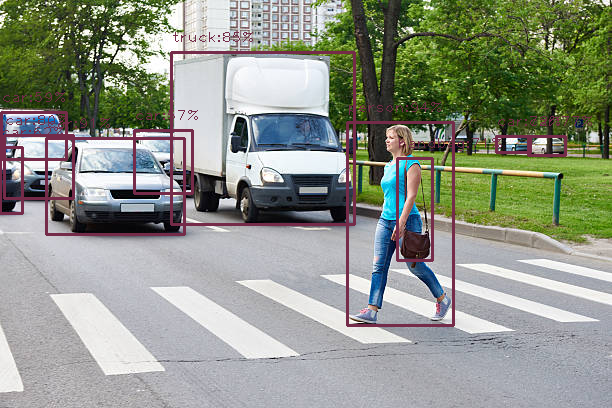

In [ ]:
modelUrl="http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz"
filename="coco.names"
magic.readClasses(filename)
magic.GetModel(modelUrl)
magic.loadModel()
imagepath="./test.jpg"
magic.predict(imagepath)